# Object detection with Retinanet

We are using this algorithm: https://github.com/fizyr/keras-retinanet

Retinanet is an object detection algorithm.

In addition to the requirements in the`requirements.txt` file, we also need to install `keras-retinanet` using 
```
pip install keras-retinanet
```

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:232: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
from pyclouds.imports import *
from pyclouds.helpers import *
from pyclouds.zooniverse import *
from pyclouds.plot import *
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import pickle
from itertools import combinations

## Prepare the data

We need to create a validation and training csv file that contains `filename, x1, y1, x2, y2, class`. So this is essentially one row per box. 

### Load and prepare the annotations CSV file.

Let's load the annotation file from the basic-analysis notebook. This is for the full dataset without the not-logged-in users.

In [ ]:
annos_full = pd.read_pickle('../preprocessed_data_original/annos_full.pkl')

In [ ]:
annos_full.head()

In [ ]:
len(annos_full)

In [ ]:
# This is where the images are stored
IMGDIR = '/local/S.Rasp/cloud-classification/'

In [ ]:
# Only extract the relevant quantities
annos_ret = annos_full[['fn', 'x', 'y', 'width', 'height', 'tool_label']]

In [ ]:
annos_ret.head()

#### Convert xywh to x1y1x2y2

In [ ]:
annos_ret['width'] = annos_full.apply(lambda r: wh2xy(r.x, r.y, r.width, r.height)[2], axis=1)
annos_ret['height'] = annos_full.apply(lambda r: wh2xy(r.x, r.y, r.width, r.height)[3], axis=1)

In [ ]:
# Additionally convert x and y to float type. Pickling seems to cast everything as object types
annos_ret['x'] = annos_ret['x'].astype(float)
annos_ret['y'] = annos_ret['y'].astype(float)

#### Prepend file path to filenames

In [ ]:
annos_ret['fn'] = annos_ret['fn'].apply(lambda fn: IMGDIR + fn)

In [ ]:
annos_ret.head()

#### Fix obviously unrealistic values

Some of the coordinates are either less than 0 or larger than the max image size. We will clip them to their max/min allowed values.

In [ ]:
annos_ret.describe()

First we will remove the entries where the lower left coordinates exceed the upper right coordinate of the image.

In [ ]:
annos_ret = annos_ret[annos_ret.x.apply(lambda x: np.isnan(x) or x < 2099)]
annos_ret = annos_ret[annos_ret.y.apply(lambda x: np.isnan(x) or x < 2099)]

In [ ]:
annos_ret.iloc[:7]

Then we will clip the values. We will also make sure that the upper right coordinates are at least 1. Zero would lead to a non-existing box.

In [ ]:
# Fix wrong values
annos_ret['x'] = np.maximum(annos_ret['x'], 0)
annos_ret['y'] = np.maximum(annos_ret['y'], 0)
annos_ret['width'] = np.maximum(np.minimum(annos_ret['width'], 2100), 1)
annos_ret['height'] = np.maximum(np.minimum(annos_ret['height'], 1400), 1)

Finally, we will round the values to integers.

In [ ]:
for c in ['x', 'y', 'width', 'height']:
    annos_ret[c] = annos_ret[c].round()

In [ ]:
annos_ret.iloc[:7]

#### Some annoying technical stuff to save the values as integers

In [ ]:
# First, replace all NaNs with empty strings
annos_ret.replace(np.nan, '', inplace=True)

In [ ]:
annos_ret.iloc[:7]

Then cast all values as strings.

In [ ]:
annos_ret[['x', 'y', 'width', 'height']] = annos_ret[['x', 'y', 'width', 'height']].astype(str)

In [ ]:
annos_ret.head()

Unfortunately, we need to remove the .0 at the end using some ugly trick.

In [ ]:
for c in ['x', 'y', 'width', 'height']:
    annos_ret[c] = annos_ret[c].apply(lambda s: s[:-2] if len(s)>0 else s)

In [ ]:
annos_ret.head()

In [ ]:
len(annos_ret)

Now we have the rows in the format we need.

### Split into train and valid

Next we need to get a reproducible train valid split. The order of images is already random in the way they were presented on Zooniverse. So we will just make a hard cut. Later we can separate different regions.

In [ ]:
# Get a list of all subjects
all_subj = list(set(annos_full.fn))

In [ ]:
all_subj[:5]

Unfortunately there are some corrupted image files (probably just on my end). As you can see below, the number is not significant. So we will just throw them out.

In [ ]:
# # Test image files
# bad_files = []
# for s in tqdm(all_subj):
#     try:
#         img = np.asarray(Image.open(SSDDIR + s).convert('RGB'))
#     except:
#         bad_files.append(s)

In [ ]:
bad_files = ['Region3_SON_Aqua/Aqua_CorrectedReflectance20151003_-135--114_-15--1.jpeg',
 'Region3_SON_Aqua/Aqua_CorrectedReflectance20091028_-135--114_-15--1.jpeg',
 'Region1_MAM_Terra/Terra_CorrectedReflectance20170302_-61--40_10-24.jpeg',
 'Region1_MAM_Terra/Terra_CorrectedReflectance20070512_-61--40_10-24.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20170221_-61--40_10-24.jpeg',
 'Region2_DJF_Terra/Terra_CorrectedReflectance20071208_159-180_8-22.jpeg',
 'Region3_SON_Aqua/Aqua_CorrectedReflectance20161022_-135--114_-15--1.jpeg',
 'Region3_SON_Terra/Terra_CorrectedReflectance20091021_-135--114_-15--1.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20130116_-61--40_10-24.jpeg',
 'Region2_DJF_Aqua/Aqua_CorrectedReflectance20101201_159-180_8-22.jpeg',
 'Region1_DJF_Terra/Terra_CorrectedReflectance20070227_-61--40_10-24.jpeg',
 'Region1_MAM_Terra/Terra_CorrectedReflectance20130308_-61--40_10-24.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20110211_-61--40_10-24.jpeg',
 'Region3_DJF_Terra/Terra_CorrectedReflectance20140123_-135--114_-15--1.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20071217_-61--40_10-24.jpeg',
 'Region2_DJF_Terra/Terra_CorrectedReflectance20170224_159-180_8-22.jpeg',
 'Region3_DJF_Terra/Terra_CorrectedReflectance20080101_-135--114_-15--1.jpeg',
 'Region3_DJF_Aqua/Aqua_CorrectedReflectance20071218_-135--114_-15--1.jpeg',
 'Region3_DJF_Aqua/Aqua_CorrectedReflectance20071201_-135--114_-15--1.jpeg',
 'Region2_DJF_Terra/Terra_CorrectedReflectance20171213_159-180_8-22.jpeg',
 'Region3_DJF_Aqua/Aqua_CorrectedReflectance20090111_-135--114_-15--1.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20071207_-61--40_10-24.jpeg',
 'Region3_DJF_Terra/Terra_CorrectedReflectance20070103_-135--114_-15--1.jpeg',
 'Region2_DJF_Terra/Terra_CorrectedReflectance20161220_159-180_8-22.jpeg']

In [ ]:
len(all_subj)

In [ ]:
all_subj = [s for s in all_subj if s not in bad_files]

In [ ]:
len(all_subj)

#### Random

In total there are around 10k images. Let's do a random 80/20 split. The images are already in random order it seems.

In [ ]:
train_subj = all_subj[:8000]
valid_subj = all_subj[8000:]

In [ ]:
with open('/local/S.Rasp/tmp/subj_fns_random.pkl', 'wb') as f:
    pickle.dump((all_subj, train_subj, valid_subj), f)

Now we need to pick all corresponding annotations.

In [ ]:
annos_ret_train = annos_ret[annos_ret.fn.apply(lambda fn: fn[len(IMGDIR):] in train_subj)]

In [ ]:
annos_ret_valid = annos_ret[annos_ret.fn.apply(lambda fn: fn[len(IMGDIR):] in valid_subj)]

In [ ]:
len(annos_ret), len(annos_ret_train), len(annos_ret_valid)

In [ ]:
annos_ret_train.to_csv('/project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv', header=False, index=False)

In [ ]:
annos_ret_valid.to_csv('/project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv', header=False, index=False)

#### By region

We can also split the train validation sets by region, which gives us a more realistic performance check for the algorithm.

In [ ]:
subj_id2name = {60811:'Region1_DJF_Aqua',60812:'Region1_DJF_Terra',60813: 'Region1_MAM_Aqua',
                60814: 'Region1_MAM_Terra',60815:'Region2_DJF_Aqua',60816:'Region2_DJF_Terra',
                60817:'Region3_DJF_Aqua', 60818:'Region3_DJF_Terra',60819:'Region3_SON_Aqua',
                60835: 'Region3_SON_Terra'}

In [ ]:
valid_subj = [s for s in all_subj if 'Region2' in s]
train_subj = [s for s in all_subj if 'Region2' not in s]

In [ ]:
len(valid_subj), len(train_subj)

In [ ]:
annos_ret_train = annos_ret[annos_ret.fn.apply(lambda fn: fn[len(IMGDIR):] in train_subj)]

In [ ]:
annos_ret_valid = annos_ret[annos_ret.fn.apply(lambda fn: fn[len(IMGDIR):] in valid_subj)]

In [ ]:
len(annos_ret), len(annos_ret_train), len(annos_ret_valid)

In [ ]:
annos_ret_train.to_csv('/project/meteo/work/S.Rasp/tmp/annos_ret_train_region.csv', header=False, index=False)

In [ ]:
annos_ret_valid.to_csv('/project/meteo/work/S.Rasp/tmp/annos_ret_valid_region.csv', header=False, index=False)

#### Using Hauke's IR criterion


In [ ]:
annos_ir = pd.read_csv('../preprocessed_data/annotations_fulldataset_IRchecked_285.csv', header=None, index_col=0)

In [ ]:
annos_ir.head()

In [ ]:
annos_ir = annos_ir.rename(columns={i+1: c for i, c in enumerate(annos_ret.columns)})

In [ ]:
annos_ir = annos_ir[annos_ir.fn.apply(lambda fn : fn not in bad_files)]

In [ ]:
# I think they are already in x1, y1, x2, y2 format
# annos_ir['width'] = annos_ir.apply(lambda r: wh2xy(r.x, r.y, r.width, r.height)[2], axis=1)
# annos_ir['height'] = annos_ir.apply(lambda r: wh2xy(r.x, r.y, r.width, r.height)[3], axis=1)

In [ ]:
# Additionally convert x and y to float type. Pickling seems to cast everything as object types
annos_ir['x'] = annos_ir['x'].astype(float)
annos_ir['y'] = annos_ir['y'].astype(float)

In [ ]:
annos_ir['fn'] = annos_ir['fn'].apply(lambda fn: IMGDIR + fn)

In [ ]:
annos_ir = annos_ir[annos_ir.x.apply(lambda x: np.isnan(x) or x < 2099)]
annos_ir = annos_ir[annos_ir.y.apply(lambda x: np.isnan(x) or x < 2099)]

In [ ]:
# Fix wrong values
annos_ir['x'] = np.maximum(annos_ir['x'], 0)
annos_ir['y'] = np.maximum(annos_ir['y'], 0)
annos_ir['width'] = np.maximum(np.minimum(annos_ir['width'], 2100), 1)
annos_ir['height'] = np.maximum(np.minimum(annos_ir['height'], 1400), 1)

In [ ]:
for c in ['x', 'y', 'width', 'height']:
    annos_ir[c] = annos_ir[c].round()

In [ ]:
# First, replace all NaNs with empty strings
annos_ir.replace(np.nan, '', inplace=True)

In [ ]:
annos_ir[['x', 'y', 'width', 'height']] = annos_ir[['x', 'y', 'width', 'height']].astype(str)

In [ ]:
for c in ['x', 'y', 'width', 'height']:
    annos_ir[c] = annos_ir[c].apply(lambda s: s[:-2] if len(s)>0 else s)

In [ ]:
annos_ir.head()

In [ ]:
annos_ir_train = annos_ir[annos_ir.fn.apply(lambda fn: 'Region2' not in fn)]
annos_ir_valid = annos_ir[annos_ir.fn.apply(lambda fn: 'Region2' in fn)]

In [ ]:
len(annos_ir), len(annos_ir_train), len(annos_ir_valid)

In [ ]:
annos_ir_train.to_csv('/project/meteo/work/S.Rasp/tmp/annos_ir_train_region.csv', header=False, index=False)

In [ ]:
annos_ir_valid.to_csv('/project/meteo/work/S.Rasp/tmp/annos_ir_valid_region.csv', header=False, index=False)

### Class csv

Finally, we also need a csv file with all the classes.

In [ ]:
clas_df = pd.DataFrame(data={'name': ['Flower', 'Fish', 'Gravel', 'Sugar'], 'id': range(4)})

In [ ]:
clas_df

In [ ]:
clas_df.to_csv('/project/meteo/work/S.Rasp/tmp/clas_ret.csv', header=False, index=False)

## Retinanet experiments

Here is the code I am using to run the keras-retinanet version. 

With a batch size of 4 and a training dataset size of around 40k, you would get around 10k steps per epoch. For more frequent evaluation/saving, I will chose 2k.


Note that I made slight changes to the keras-retinanet code to allow for variable anchor sizes and seeing the actual validation score, not just the mAP. Contact me if you are interested in those.

For the "best" network version, I don't need any of these though. 

Here is the command line prompt to train a model. Of course you need to change the paths for your image and csv locations. A batch size of four with a max image size of 1050 requires 15.4GB of GPU RAM. One epoch takes around 1.5h on a Quadro P5000:

```shell
retinanet-train \
--gpu 1 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp0/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_region.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_region.csv
```

Below are some of my hyper-parameter experiments...

### Experiment 1: My best guess

```shell
keras_retinanet/bin/train.py \
--gpu 0 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--random-transform \
--min_anchor_size 64 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp1/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
Epoch 13/20
2000/2000 [==============================] - 2795s 1s/step - loss: 2.2014 - regression_loss: 1.8453 - classification_loss: 0.3561
1509 instances of class Flower with average precision: 0.1933
1754 instances of class Fish with average precision: 0.1004
1844 instances of class Gravel with average precision: 0.1084
2725 instances of class Sugar with average precision: 0.0872
mAP: 0.1223

val_loss: 2.5161 - val_regression_loss: 2.1244 - val_classification_loss: 0.3917


Epoch 20/20
2000/2000 [==============================] - 2570s 1s/step - loss: 2.1367 - regression_loss: 1.7926 - classification_loss: 0.3442
1509 instances of class Flower with average precision: 0.1337
1754 instances of class Fish with average precision: 0.0973
1844 instances of class Gravel with average precision: 0.0835
2725 instances of class Sugar with average precision: 0.0862
mAP: 0.1002

val_loss: 2.5526 - val_regression_loss: 2.1750 - val_classification_loss: 0.3777

```

### Experiment 2: Exp 1 with nms_iou=0.3

```shell
keras_retinanet/bin/train.py \
--gpu 1 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--random-transform \
--min_anchor_size 64 \
--nms_iou 0.3 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp2/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
Epoch 20/20
2000/2000 [==============================] - 2678s 1s/step - loss: 2.1389 - regression_loss: 1.7934 - classification_loss: 0.3455
1509 instances of class Flower with average precision: 0.0979
1754 instances of class Fish with average precision: 0.0590
1844 instances of class Gravel with average precision: 0.0496
2725 instances of class Sugar with average precision: 0.0424
mAP: 0.0622

val_loss: 2.5312 - val_regression_loss: 2.1484 - val_classification_loss: 0.3828
```

### Experiment 3: Exp 1 without data augmentation

```shell
keras_retinanet/bin/train.py \
--gpu 2 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--min_anchor_size 64 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp3/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
Epoch 20/20
2000/2000 [==============================] - 1913s 957ms/step - loss: 1.8668 - regression_loss: 1.5396 - classification_loss: 0.3271
1509 instances of class Flower with average precision: 0.1712
1754 instances of class Fish with average precision: 0.1005
1844 instances of class Gravel with average precision: 0.1047
2725 instances of class Sugar with average precision: 0.0990
mAP: 0.1189

val_loss: 2.1677 - val_regression_loss: 1.8139 - val_classification_loss: 0.3537
```

### Experiment 4: Exp 1 without default anchor sizes

```shell
keras_retinanet/bin/train.py \
--gpu 3 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp4/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
Epoch 20/20
2000/2000 [==============================] - 2595s 1s/step - loss: 1.8765 - regression_loss: 1.5490 - classification_loss: 0.3275
1509 instances of class Flower with average precision: 0.4345
1754 instances of class Fish with average precision: 0.3552
1844 instances of class Gravel with average precision: 0.3331
2725 instances of class Sugar with average precision: 0.3953
mAP: 0.3795

val_loss: 2.1927 - val_regression_loss: 1.8330 - val_classification_loss: 0.3597
```

### Experiment 5: Exp 4 with region validation

```shell
keras_retinanet/bin/train.py \
--gpu 3 \
--valid \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp5/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_region.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_region.csv
```

```
Epoch 1/1
2/2 [==============================] - 139s 70s/step - loss: 1.8181 - regression_loss: 1.4486 - classification_loss: 0.3694 - val_loss: 2.2597 - val_regression_loss: 1.8873 - val_classification_loss: 0.3724
803 instances of class Flower with average precision: 0.3934
2777 instances of class Fish with average precision: 0.3552
2621 instances of class Gravel with average precision: 0.3225
3846 instances of class Sugar with average precision: 0.3828
mAP: 0.3635
```

### Experiment 6: Exp 4 from snapshot with larger img_size

```shell
keras_retinanet/bin/train.py \
--snapshot  /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp4/resnet50_csv_20.h5 \
--valid \
--gpu 2 \
--epochs 20 \
--batch-size 2 \
--steps 2000 \
--image-max-side 1600 \
--image-min-side 1600 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp6/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ret_train_random.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv
```

```
val_loss: 2.1770 - val_regression_loss: 1.8083 - val_classification_loss: 0.3686
1509 instances of class Flower with average precision: 0.4351
1754 instances of class Fish with average precision: 0.3429
1844 instances of class Gravel with average precision: 0.3260
2725 instances of class Sugar with average precision: 0.3980
mAP: 0.3755
```

### Experiment 7: Using Hauke's IR filtered dataset

```shell
keras_retinanet/bin/train.py \
--gpu 0 \
--epochs 20 \
--batch-size 4 \
--steps 2000 \
--image-max-side 1050 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/exp7/ \
csv /project/meteo/work/S.Rasp/tmp/annos_ir_train_region.csv /project/meteo/work/S.Rasp/tmp/clas_ret.csv \
--val-annotations /project/meteo/work/S.Rasp/tmp/annos_ir_valid_region.csv
```

```
Epoch 20/20
2000/2000 [==============================] - 1720s 860ms/step - loss: 1.8002 - regression_loss: 1.4497 - classification_loss: 0.3505
593 instances of class Flower with average precision: 0.3561
1984 instances of class Fish with average precision: 0.3151
2074 instances of class Gravel with average precision: 0.2785
3017 instances of class Sugar with average precision: 0.3215
mAP: 0.3178
```

## Check out predictions

In [3]:
# import keras_retinanet
import keras
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [4]:
SAVEDIR = '/project/meteo/work/S.Rasp/cloud-classification/pretrained_weights/'

In [5]:
!ls $SAVEDIR

exp4_resnet50_csv_20.h5  exp5_resnet50_csv_20.h5


### Load model

In [6]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = f'{SAVEDIR}exp5_resnet50_csv_20.h5'#os.path.join('/local/S.Rasp/tmp/', 'resnet50_csv_25.h5')

# load retinanet model
#model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
model = models.load_model(model_path, backbone_name='resnet50', convert=True)

#print(model.summary())

# load label to names mapping for visualization purposes

#labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
labels_to_names = {i: l for i, l in enumerate(['Flower', 'Fish', 'Gravel', 'Sugar'])}

In [7]:
model_path = f'{SAVEDIR}exp4_resnet50_csv_20.h5'
model4 = models.load_model(model_path, backbone_name='resnet50', convert=True)

### Plot some predictions

In [ ]:
val_df = pd.read_csv('/project/meteo/work/S.Rasp/tmp/annos_ret_valid_region.csv', header=None)

In [ ]:
val_fns = list(val_df[0].unique()); len(val_fns)

In [ ]:
def get_retinanet_preds(model, fn, thresh=0.5, min_side=800, max_side=1050):
    image = read_image_bgr(fn)
    image = preprocess_image(image)
    image, scale = resize_image(image, min_side, max_side)
    boxes, scores, labels = [o[0] for o in model.predict_on_batch(np.expand_dims(image, axis=0))]
    boxes /= scale
    boxes = boxes[scores > thresh]
    boxes = [xy2wh(*b) for b in boxes]
    labels = labels[scores > thresh]
    labels = [labels_to_names[i] for i in labels]
    scores = scores[scores > thresh]
    return np.array(boxes), labels, scores

In [ ]:
def plot_img_from_fn_and_boxes(fn, boxes, labels, scores, figsize=(18, 15), show_labels=True):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    img = Image.open(fn)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    for i in range(boxes.shape[0]):
        rect = patches.Rectangle((boxes[i, 0], boxes[i, 1]), boxes[i, 2], boxes[i, 3],
                                 facecolor='none',
                                 edgecolor=np.array(l2c[labels[i]]) / 255, lw=2)
        ax.add_patch(rect)
        if show_labels:
            s = labels[i] + ' - Retinanet - ' + str(scores[i])[:4]
            txt = ax.text(boxes[i, 0], boxes[i, 1], s, color='white', fontsize=15, va='top')
            txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])

In [ ]:
def plot_retinanet(model, fn, thresh=0.5):
    boxes, labels, scores = get_retinanet_preds(model, fn, thresh)
    plot_img_from_fn_and_boxes(fn, boxes, labels, scores)

In [ ]:
plot_retinanet(model, val_fns[4])

In [ ]:
plot_retinanet(model4, val_fns[4])

In [ ]:
fn2id = {IMGDIR + r.fn: r.subject_ids for i, r in annos_full.iterrows()}

In [ ]:
plot_img_with_annos(fn2id[val_fns[4]], IMGDIR, annos_full)

### Get prediction for synthetic model output image

In [ ]:
img = Image.open('/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb.png')

In [ ]:
sz = img.size; sz

In [ ]:
scale = sz[0] / 2100; scale

In [ ]:
new_size = np.array(sz) / scale; new_size

In [ ]:
img_small = img.resize(new_size.astype(int))

In [ ]:
img_small

In [ ]:
img_small.save('/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb_small.png')

In [ ]:
plot_retinanet(model, '/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb_small.png', 0.3)

In [ ]:
plot_retinanet(model4, '/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb_small.png', 0.3)

## Save predictions for validation dataset

In [ ]:
def get_preds_for_fns(fns, model, thresh=0.5):
    dfs=[]
    for fn in tqdm(fns):
        boxes, labels, scores = get_retinanet_preds(model, fn, thresh)
        if len(labels) == 0:
            boxes = np.array([[np.nan]*4])
            labels = [np.nan]
            names = 'Retinanet'
        else:
            names = ['Retinanet - ' + str(s)[:4] for s in scores]
        
        dfs.append(pd.DataFrame(data={
            'subject_ids': fn2id[fn],
            'fn': fn,
            'user_name': names,
            'tool_label': labels, 
            'x': boxes[:, 0],
            'y': boxes[:, 1],
            'width': boxes[:, 2],
            'height': boxes[:, 3],
        }))
    return pd.concat(dfs)

In [ ]:
val_df = get_preds_for_fns(val_fns, model)

In [ ]:
val_df.to_csv('/project/meteo/work/S.Rasp/cloud-classification/ml/retinanet_val_preds_region.csv')

## Get predictions for the entire world

In [8]:
world_fns = sorted(glob('/project/meteo/work/S.Rasp/cloud-classification/world/Aqua*_-90-90*')) 

In [9]:
len(world_fns)

365

In [10]:
img = read_image_bgr(world_fns[0])

In [11]:
img.shape

(9000, 18000, 3)

In [111]:
def get_retinanet_preds_from_img(model, image, thresh=0.5, max_side=1050):
    #pdb.set_trace()
    image = preprocess_image(image)
    image, scale = resize_image(image, max_side)
    boxes, scores, labels = [o[0] for o in model.predict_on_batch(np.expand_dims(image, axis=0))]
    boxes /= scale
    return np.array(boxes), scores, labels

In [13]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return pick

In [121]:
def get_world_retinanet_img(model, fn, thresh=0.5, nms_thresh=0.3, 
                            noprog=False, return_non_nms=False):
    #pdb.set_trace()
    img = read_image_bgr(fn)
    dx = 1400 // 2
    dy = 2100 // 2
    nx = img.shape[0] // dx
    ny = img.shape[1] // dy
    img = img[:nx*dx, :ny*dy]
    
    all_boxes = []
    all_scores = []
    all_labels = []
    for i in tqdm(np.arange(0, img.shape[0], dx//2), disable=noprog):
        for j in np.arange(0, img.shape[1], dy//2):
            img_cut = img[i:i+dx, j:j+dy]
            boxes, scores, labels = get_retinanet_preds_from_img(model, img_cut)
            # boxes are [x1, y1, x2, y2]
            if boxes.size > 0:
                boxes[:, 0] += j; boxes[:, 2] += j
                boxes[:, 1] += i; boxes[:, 3] += i
                all_boxes.append(boxes)
                all_scores.extend(scores)
                all_labels.extend(labels)
    
    ab = np.concatenate(all_boxes)
    all_scores = np.array(all_scores); all_labels = np.array(all_labels)
    score_idx = np.array(all_scores) > thresh
    
    ab = ab[score_idx]
    all_scores = all_scores[score_idx]
    all_labels = all_labels[score_idx]
    
    pick = non_max_suppression_fast(ab, nms_thresh)
    
    
    if return_non_nms:
        return (ab[pick], all_scores[pick], all_labels[pick]), (ab, all_scores, all_labels), img
    else:
        ab = ab[pick]
        all_scores = all_scores[pick]
        all_labels = all_labels[pick]
        return ab, all_scores, all_labels, img
    #get_retinanet_img_from_boxes(img, ab, all_scores, all_labels, figsize=(25, 25), thresh=thresh)

In [117]:
boxes, scores, labels, img = get_world_retinanet_img(model4, world_fns[100],
                                                    nms_thresh=0.3)

In [94]:
def get_retinanet_img_from_boxes(img, boxes, scores, labels, thresh = 0.5, figsize=(15, 15)):
    
    draw = img.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    # visualize detections
    for box, score, label in zip(boxes, scores, labels):
        # scores are sorted so we can break
        if score >= thresh:


            color = l2c[labels_to_names[label]]  #label_color(label)

            b = box.astype(int)
            draw_box(draw, b, color=color, thickness=35)

            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)

    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [114]:
img.shape

(8400, 17850, 3)

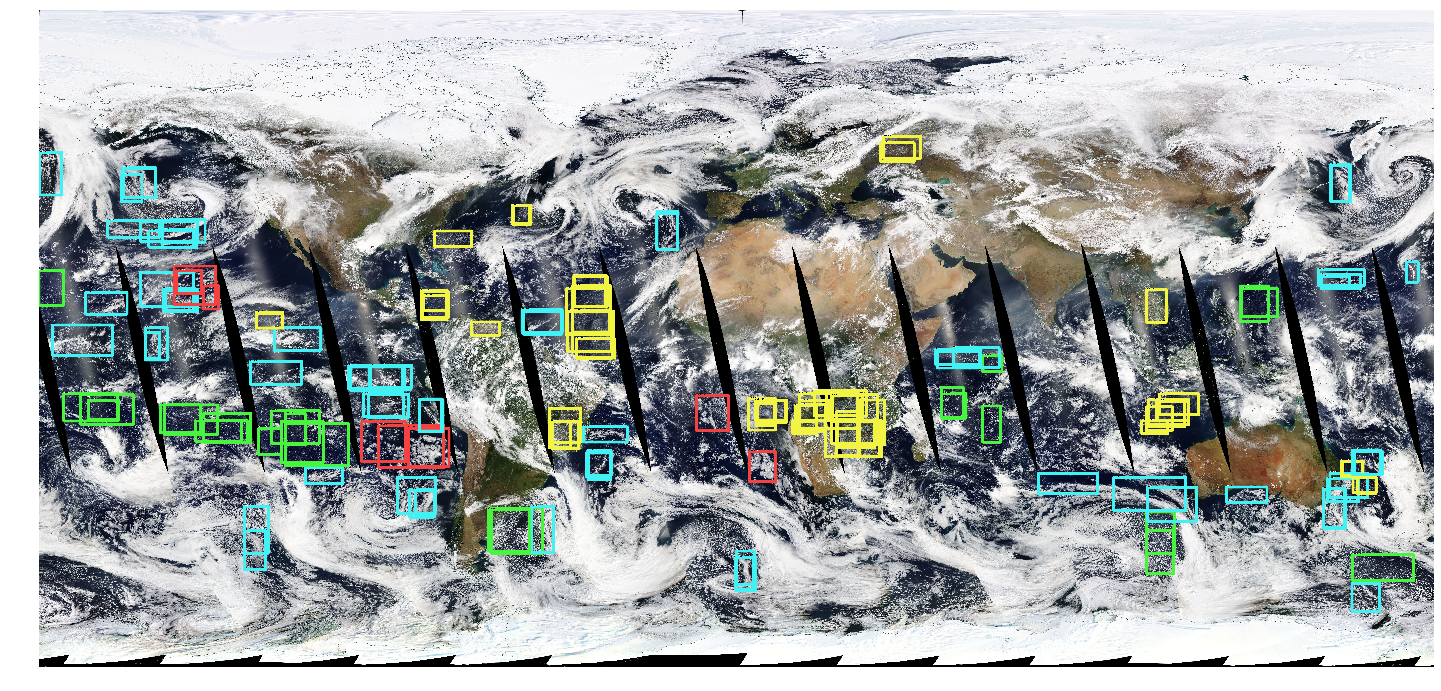

In [118]:
get_retinanet_img_from_boxes(img, boxes, scores, labels, figsize=(25, 25), thresh=0.5)

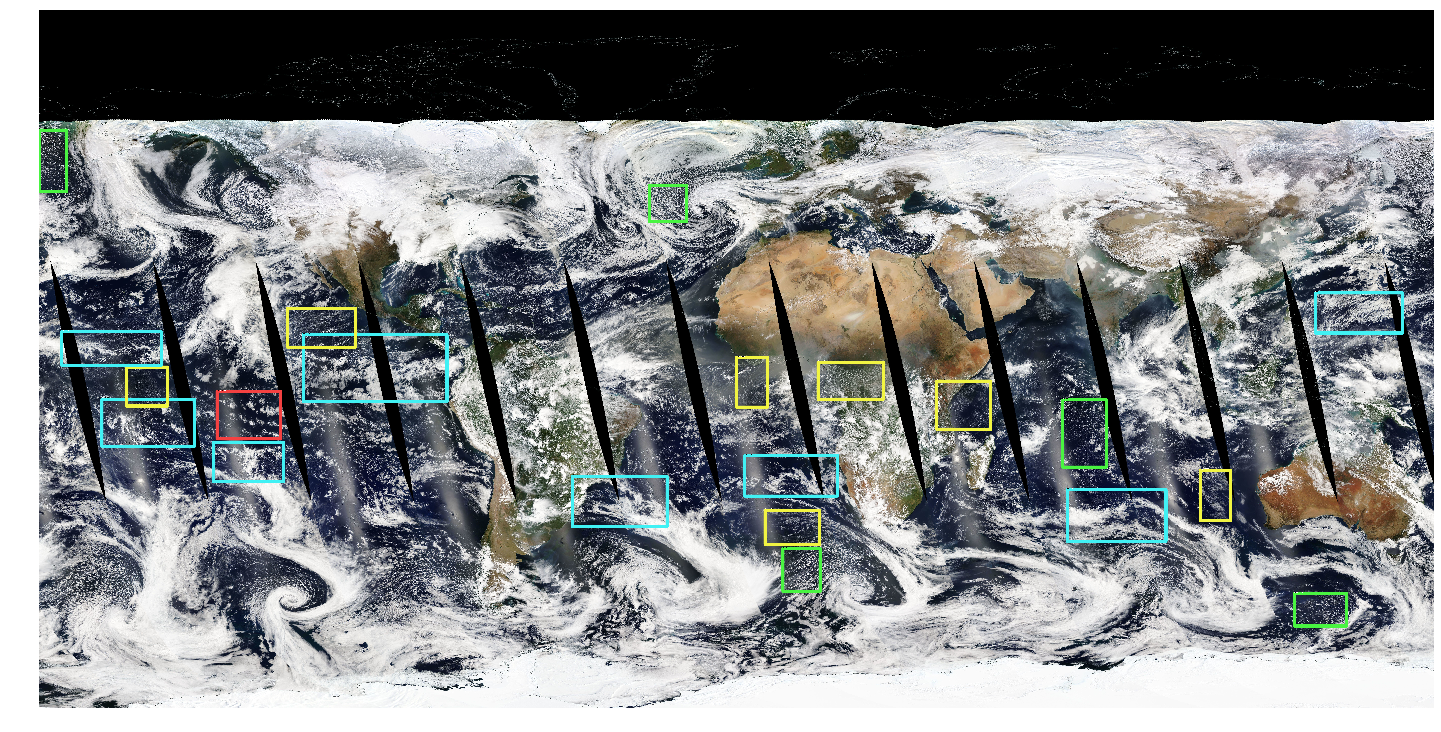

In [95]:
get_retinanet_img_from_boxes(img, boxes, scores, labels, figsize=(25, 25), thresh=0.5)

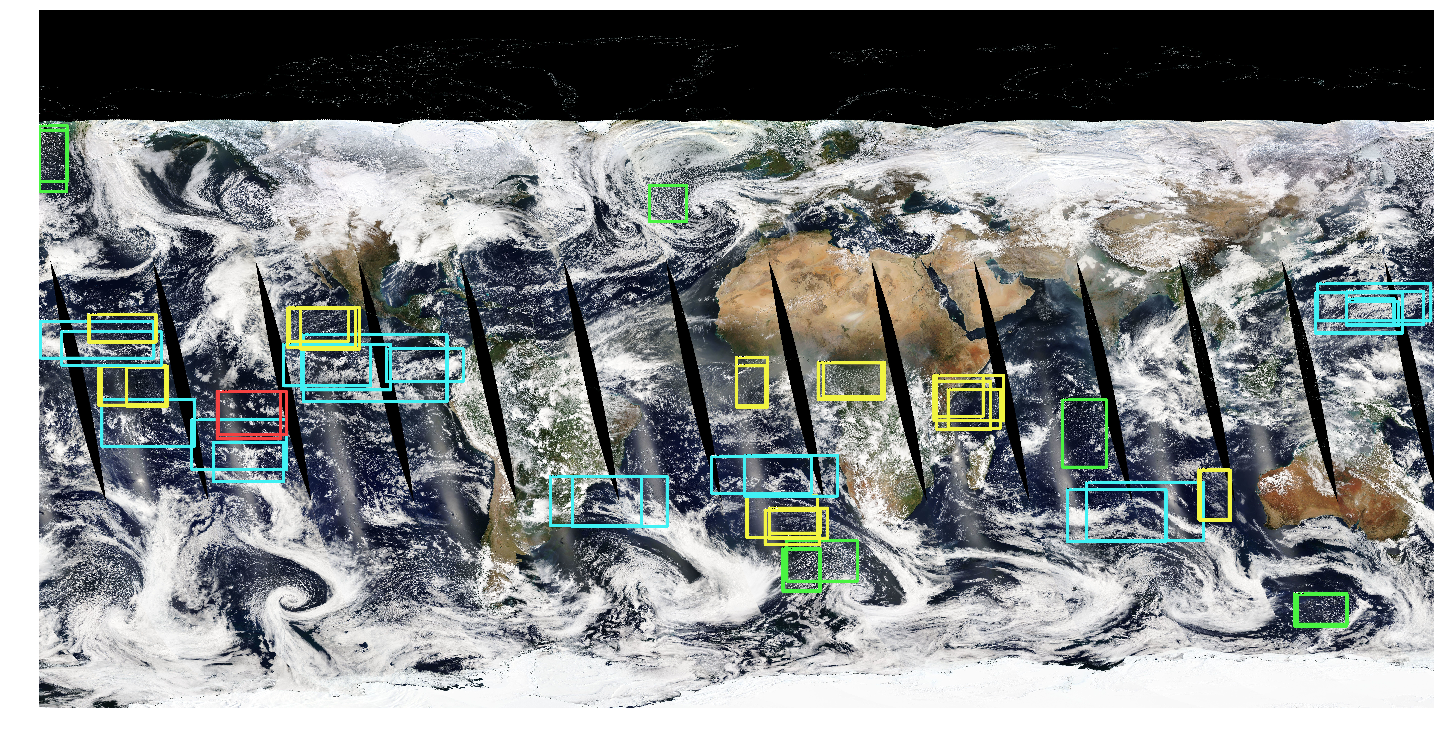

In [101]:
get_retinanet_img_from_boxes(img, boxes, scores, labels, figsize=(25, 25), thresh=0.5)

### Loop over year

In [120]:
all_boxes, all_scores, all_labels = [], [], []
all_boxes_nms, all_scores_nms, all_labels_nms = [], [], []

In [124]:
%%time
for fn in tqdm(world_fns):
    
    nms, non_nms, img = get_world_retinanet_img(model4, fn, noprog=True,
                                               return_non_nms=True)
    del img
    boxes, scores, labels = non_nms
    boxes_nms, scores_nms, labels_nms = nms
    all_boxes.append(boxes)
    all_scores.append(scores)
    all_labels.append(labels)
    all_boxes_nms.append(boxes_nms)
    all_scores_nms.append(scores_nms)
    all_labels_nms.append(labels_nms)
    
with open('/project/meteo/work/S.Rasp/cloud-classification/ml/retina_all.pkl', 'wb') as f:
    pickle.dump((all_boxes, all_scores, all_labels), f)
with open('/project/meteo/work/S.Rasp/cloud-classification/ml/retina_all_nms.pkl', 'wb') as f:
    pickle.dump((all_boxes_nms, all_scores_nms, all_labels_nms), f)

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f81fc126938>
Traceback (most recent call last):
  File "/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


KeyboardInterrupt: 

In [127]:
len(all_boxes_nms)

365

In [139]:
tot_pred = np.zeros([4, 17850, 8400])
for b, s, l in zip(all_boxes, all_scores, all_labels):
    b = np.round(b).astype(int)
    tp = np.zeros([4, 17850, 8400])
    for i in range(len(b)):
        tp[l[i], b[i, 0]:b[i, 2], b[i, 1]:b[i, 3]] = 1
    tot_pred += tp
tot_pred /= len(all_boxes)

In [140]:
np.save('/project/meteo/work/S.Rasp/cloud-classification/ml/retina_mean.npy', tot_pred)

In [132]:
world_size = [18000, 9000]

In [133]:
# Shoddy way to figure out lats and lons for image.
lons = np.linspace(-180,180,18000)
lats = np.linspace(90,-90,9000)
lons = lons[:17850]
lats = lats[-8400:]
max_lon, min_lat = lons[-1], lats[0]; max_lon, min_lat

(176.99983332407356, 77.99866651850206)

In [134]:
import cartopy.crs as ccrs
from scipy.ndimage import zoom

In [135]:
def plot_heatmap(mask, z=0.3, figsize=(6,6), save=None, title='', cblabel='',
                 levels=np.arange(0.05, 0.85, 0.05)):
    z = 0.3
    mask_re = zoom(mask, (z, z))
    nlat, nlon = mask_re.shape
    lons = np.linspace(-180,max_lon,nlon)
    lats = np.linspace(90,-min_lat,nlat)
    
    fig = plt.figure(figsize = figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.contourf(lons, lats, mask_re, transform=ccrs.PlateCarree(), cmap='gnuplot2_r', 
                 levels=levels, extend='both')
    ax.coastlines()
    plt.title(title)
    cb = plt.colorbar(orientation='horizontal', pad=0.01, extend='both', shrink=0.7)
    cb.ax.set_xlabel(cblabel)
    plt.tight_layout()
    if save is not None:
        fig.savefig(save, dpi=300, bbox_inches='tight')

In [136]:
labels_to_names

{0: 'Flower', 1: 'Fish', 2: 'Gravel', 3: 'Sugar'}

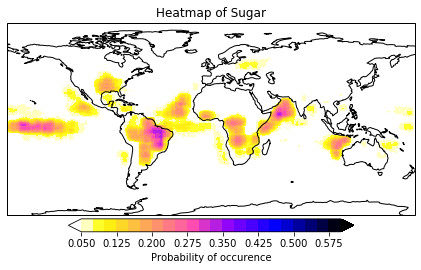

In [141]:
plot_heatmap(tot_pred[3].T, levels=np.arange(0.05, 0.625, 0.025), 
             title='Heatmap of Sugar',
             cblabel='Probability of occurence')

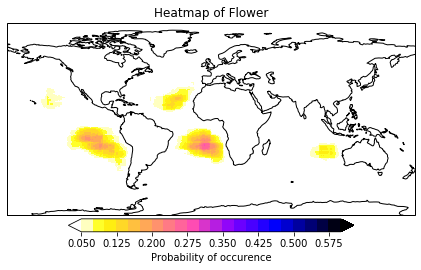

In [142]:
plot_heatmap(tot_pred[0].T, levels=np.arange(0.05, 0.625, 0.025), 
             title='Heatmap of Flower',
             cblabel='Probability of occurence')

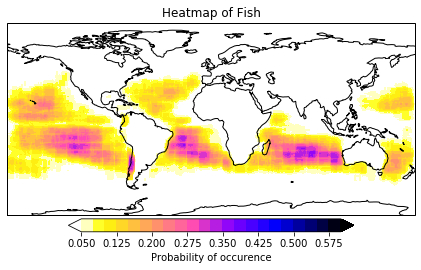

In [143]:
plot_heatmap(tot_pred[1].T, levels=np.arange(0.05, 0.625, 0.025), 
             title='Heatmap of Fish',
             cblabel='Probability of occurence')

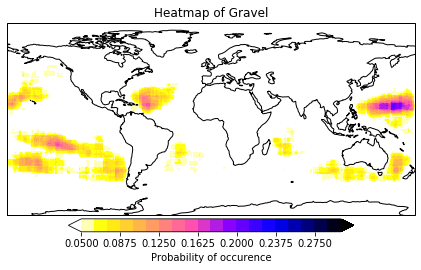

In [144]:
plot_heatmap(tot_pred[2].T, levels=np.arange(0.05, 0.3125, 0.0125), 
             title='Heatmap of Gravel',
             cblabel='Probability of occurence')

### Create CSV 

In [51]:
def x2lon(x): return x/18000 * 360 - 180

In [63]:
def y2lat(y): return -(y/9000 * 180 - 90)

In [68]:
ntot = np.concatenate(all_boxes).shape[0]

In [69]:
ntot

8762

In [76]:
dates = np.arange(
    np.datetime64('2017-01-01'), np.datetime64('2018-01-01'),
    np.timedelta64(1, 'D'))

In [74]:
df = pd.DataFrame(
    index=range(ntot), 
    columns=['Date', 'label', 'lon1', 'lon2', 'lat1', 'lat2']
)

In [86]:
i = 0
for idate, date in tqdm(enumerate(dates)):
    boxes = all_boxes[idate]
    labels = all_labels[idate]
    for b, l in zip(boxes, labels):
        df.iloc[i]['Date'] = date
        df.iloc[i]['label'] = labels_to_names[l]
        df.iloc[i]['lon1'] = x2lon(b[0])
        df.iloc[i]['lon2'] = x2lon(b[2])
        df.iloc[i]['lat1'] = y2lat(b[1])
        df.iloc[i]['lat2'] = y2lat(b[3])
        
        i += 1

In [87]:
df.head()

Date   label     lon1     lon2     lat1     lat2
0  2017-01-01  Gravel -141.577 -129.794 -50.1357 -56.4438
1  2017-01-01  Gravel -21.4099 -12.8888 -44.4645 -55.8922
2  2017-01-01    Fish   135.08  142.023 -38.5443 -52.0794
3  2017-01-01  Gravel -20.1825 -1.45068 -37.1983 -51.6955
4  2017-01-01   Sugar  102.069  110.063 -19.4298 -31.6774

In [88]:
df.to_csv('./retinanet-world-2017.csv')

### Try without NMS

# OLD STUFF BELOW

### Get prediction for model image

In [ ]:
img = Image.open('/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb.png')

In [ ]:
img

In [ ]:
sz = img.size; sz

In [ ]:
scale = sz[0] / 2100; scale

In [ ]:
new_size = np.array(sz) / scale; new_size

In [ ]:
img_small = img.resize(new_size.astype(int))

In [ ]:
img_small

In [ ]:
img_small.save('/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb_small.png')

In [ ]:
get_retinanet_img(model4, '/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb_small.png', 
                  max_side=1050, thresh=0.3)

### Prepare stuff for plots

In [ ]:
subj_fn = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

In [ ]:
subj = load_classifications(subj_fn)

In [ ]:
fn2id = {}
for i, r in subj.iterrows():
    try:
        fn2id[SSDDIR + r.metadata['fn'][48:]] = r.subject_id
    except:
        print(r.subject_id)

In [ ]:
fn2id

In [ ]:
val_df = pd.read_csv('/project/meteo/work/S.Rasp/tmp/annos_ret_valid_random.csv', header=None)

In [ ]:
val_df.head()

In [ ]:
val_fns = list(set(val_df[0]))

In [ ]:
l2c = {'Sugar': [241, 244, 66], 'Flower': [244, 65, 65], 'Fish': [65, 241, 244], 'Gravel':[73, 244, 65]}

In [ ]:
def plot_img_with_annos(fn):
    l2c = {'Sugar': [241, 244, 66], 'Flower': [244, 65, 65], 'Fish': [65, 241, 244], 'Gravel':[73, 244, 65]}
    fig, ax = plt.subplots(figsize=(15, 10))
    #fn = str(SSDDIR + subj[subj.subject_id == subj_id].iloc[0]['fn'])
    img = Image.open(fn)
    ax.imshow(img)
    ans = annos_full[annos_full.subject_ids == fn2id[fn]]
    nones = []
    for i, a in ans.iterrows():
        if np.isfinite(a['x']):
            rect = patches.Rectangle((a['x'],a['y']), a['width'], a['height'], facecolor='none', 
                                     edgecolor=np.array(l2c[a['tool_label']])/255, lw=3)
            ax.add_patch(rect)
            ax.text(a['x'], a['y'], a['tool_label'] + ' - ' + a['user_name'], color=(0,1,0), fontsize=15, va='top')
        else:
            nones.append(a['user_name'])
    if len(nones) > 0:
        ax.text(0, -50, 'None: ' + str(nones), color='red', fontsize=15, va='top')

### Check model predictions

In [ ]:
def get_retinanet_img(model, fn, thresh=0.5, max_side=1333, debug=False, figsize=(15, 15)):
    # load image
    image = read_image_bgr(fn)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image, max_side=max_side, min_side=2000)
    print(image.shape)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score <= thresh:
            break

        color = l2c[labels_to_names[label]]  #label_color(label)

        b = box.astype(int)
        if debug: print(b)
        draw_box(draw, b, color=color, thickness=6)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [ ]:
fn = val_fns[58]

In [ ]:
get_retinanet_img(model, fn, max_side=1600, thresh=0.5, debug=False, figsize=(7,7))

In [ ]:
get_retinanet_img(model2, fn, max_side=1050, thresh=0.4, debug=False, figsize=(7, 7))

In [ ]:
get_retinanet_img(model3, fn, max_side=1050, thresh=0.5, debug=False, figsize=(7, 7))

In [ ]:
get_retinanet_img(model4, fn, max_side=1050, thresh=0.5)

In [ ]:
plot_img_with_annos(fn)

### Get prediction for model image

In [ ]:
img = Image.open('/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb.png')

In [ ]:
img

In [ ]:
sz = img.size; sz

In [ ]:
scale = sz[0] / 2100; scale

In [ ]:
new_size = np.array(sz) / scale; new_size

In [ ]:
img_small = img.resize(new_size.astype(int))

In [ ]:
img_small

In [ ]:
img_small.save('/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb_small.png')

In [ ]:
get_retinanet_img(model4, '/project/meteo/work/S.Rasp/cloud-classification/refl_latlon_model_MODIS_rgb_small.png', 
                  max_side=1050, thresh=0.3)

## Compute simple score for these predictions

For now, copy a lot of stuff fro the user-agreement notebook.

In [ ]:
def xy2wh(x1, y1, x2, y2):
    return [x1, y1, x2-x1, y2-y1]

In [ ]:
def get_retinanet_preds(model, fn, thresh=0.5):
    image = read_image_bgr(fn)
    image = preprocess_image(image)
    image, scale = resize_image(image)
    boxes, scores, labels = [o[0] for o in model.predict_on_batch(np.expand_dims(image, axis=0))]
    boxes /= scale
    boxes = boxes[scores > thresh]
    boxes = [xy2wh(*b) for b in boxes]
    labels = labels[scores > thresh]
    labels = [id2class[i] for i in labels]
    return np.array(boxes), labels

In [ ]:
def get_preds_for_fns(fns, model, thresh=0.5):
    dfs=[]
    for fn in tqdm(fns):
        boxes, labels = get_retinanet_preds(model, fn)
        if len(labels) == 0:
            boxes = np.array([[np.nan]*4])
            labels = [np.nan]
        
        dfs.append(pd.DataFrame(data={
            'subject_ids': fn2id[fn],
            'fn': fn,
            'user_name': 'retinanet',
            'tool_label': labels, 
            'x': boxes[:, 0],
            'y': boxes[:, 1],
            'width': boxes[:, 2],
            'height': boxes[:, 3],
        }))
    return pd.concat(dfs)

In [ ]:
preds_val_random = get_preds_for_fns(val_fns, model4)

In [ ]:
preds_val_random.head()

In [ ]:
len(preds_val_random)

In [ ]:
comb_df = pd.concat([
    annos_full[['subject_ids', 'user_name', 'tool_label', 'x', 'y', 'width', 'height']], preds_val_random])

In [ ]:
comb_df.to_csv('/local/S.Rasp/tmp/comb_ret_val_preds_random.csv')

In [ ]:
annos_full.head()

In [ ]:
annos_full.columns

So this is essentially the format we need for the retinanet predictions. Then after we need to modify the functions to hone in on a specific user.

The only columns that are actually used are user_name, subject_id, x, y, width, height and tool_label

### For a given subject_id get the predictions from Retinanet

In [ ]:
fn

In [ ]:
image = read_image_bgr(fn)
image = preprocess_image(image)

In [ ]:
image.shape

In [ ]:
image, scale = resize_image(image, max_side=700)
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

In [ ]:
image.shape

In [ ]:
scale

In [ ]:
boxes   # These are x1, y1, x1, x2

In [ ]:
boxes.shape

In [ ]:
boxes[0].max(0), boxes[0].min(0)

In [ ]:
1200 / scale, 700/scale

In [ ]:
scores.shape, labels.shape

In [ ]:
scores[0, :5]

In [ ]:
labels[0, :5]

In [ ]:
# Get only labels above thresh
thresh = 0.5

In [ ]:
(scores[0] > thresh).sum()

In [ ]:
bb = boxes[0][scores[0] > thresh]

In [ ]:
bb

In [ ]:
labels[0][scores[0] > thresh]

In [ ]:
from pyclouds.agreement import iou_one_class_from_annos

In [ ]:
iou_one_class_from_annos([xy2wh(*bb[0])], [xy2wh(*bb[3])], img_size=(1200, 800), return_iou=True)

In [ ]:
iou_one_class_from_annos([xy2wh(*bb[1])], [xy2wh(*bb[2])], img_size=(1200, 800), return_iou=True)

In [ ]:
clas_df

In [ ]:
clas_df.iloc[0]['name']

In [ ]:
id2class = {r.id: r['name'] for i, r in clas_df.iterrows()}

In [ ]:
id2class

In [ ]:
def xy2wh(x1, y1, x2, y2):
    return [x1, y1, x2-x1, y2-y1]

In [ ]:
def get_retinanet_preds(fn, thresh=0.5):
    image = read_image_bgr(fn)
    image = preprocess_image(image)
    image, scale = resize_image(image)
    boxes, scores, labels = [o[0] for o in model.predict_on_batch(np.expand_dims(image, axis=0))]
    boxes /= scale
    boxes = boxes[scores > thresh]
    boxes = [xy2wh(*b) for b in boxes]
    labels = labels[scores > thresh]
    labels = [id2class[i] for i in labels]
    return np.array(boxes), labels
    

In [ ]:
boxes, labels = get_retinanet_preds(fn)

### Now somehow put this into a data frame

In [ ]:
boxes.shape

In [ ]:
for i in range(len(labels)):
    df = pd.DataFrame(data={
        'tool_label': labels, 
        'x': boxes[:, 0],
        'y': boxes[:, 1],
        'width': boxes[:, 2],
        'height': boxes[:, 3],
    })

In [ ]:
df

### Ok, now loop over all valid fns and also get subject_id

In [ ]:
len(val_fns)

In [ ]:
dfs=[]
for fn in tqdm(val_fns):
    boxes, labels = get_retinanet_preds(fn)
    if len(labels) == 0:
        boxes = np.array([[np.nan]*4])
        labels = [np.nan]
    for i in range(len(labels)):
        dfs.append(pd.DataFrame(data={
            'subject_ids': fn2id[fn],
            'user_name': 'retinanet',
            'tool_label': labels, 
            'x': boxes[:, 0],
            'y': boxes[:, 1],
            'width': boxes[:, 2],
            'height': boxes[:, 3],
        }))

In [ ]:
ret_preds = pd.concat(dfs)

In [ ]:
ret_preds.head()

In [ ]:
len(ret_preds)

In [ ]:
ret_preds.to_csv('/local/S.Rasp/tmp/ret_val_preds.csv')

## Now comes the big one: How do we now compare that to the users.

In [ ]:
classes = list(clas_df['name'])

In [ ]:
classes

In [ ]:
def simple_agreement_by_class(subj_id, agree=None, tot=None):
    ans = annos_full[annos_full.subject_ids == subj_id]
    users = ans.user_name.unique()
    
    if agree is None: agree = defaultdict(int)
    if tot is None: tot = defaultdict(int)
    for u1, u2 in combinations(users, 2):
        for c in classes:
            a1 = ans[(ans.user_name == u1) & (ans.tool_label == c)]
            a2 = ans[(ans.user_name == u2) & (ans.tool_label == c)]
            # Option 1: both zero --> skip
            if (len(a1) == 0) & (len(a2) == 0):
                pass
            # Option 2: Both people have this class:
            elif (len(a1) > 0) and (len(a2) > 0):
                tot[c] += 2; agree[c] += 2
            # Option 3: Only one user has this class
            else:
                tot[c] += 1

    return agree , tot

In [ ]:
fn = val_fns[3]

In [ ]:
plot_img_with_annos(fn)

In [ ]:
get_retinanet_img(fn)

In [ ]:
simple_agreement_by_class(fn2id[fn])

In [ ]:
def simple_agreement_by_class_and_user(subj_id, user, agree=None, tot=None, annos=annos_full):
    ans = annos[annos.subject_ids == subj_id]
    users = ans.user_name.unique()
    #print(users)
    
    if agree is None: agree = defaultdict(int)
    if tot is None: tot = defaultdict(int)
    
    other_users = [u for u in users if u != user]
    
    if (user not in users) or (len(other_users) == 0):
        return agree, tot
    
    u1 = user
    for u2 in other_users:
        for c in classes:
            a1 = ans[(ans.user_name == u1) & (ans.tool_label == c)]
            a2 = ans[(ans.user_name == u2) & (ans.tool_label == c)]
            # Option 1: both zero --> skip
            if (len(a1) == 0) & (len(a2) == 0):
                pass
            # Option 2: Both people have this class:
            elif (len(a1) > 0) and (len(a2) > 0):
                tot[c] += 1; agree[c] += 1
            # Option 3: Only u1 has this class
            elif (len(a1) > 0) and (len(a2) == 0):
                tot[c] += 1

    return agree , tot

In [ ]:
simple_agreement_by_class_and_user(fn2id[fn], 'traute.crueger')

In [ ]:
agree = defaultdict(int)
tot = defaultdict(int)

In [ ]:
for fn in tqdm(val_fns):
    s = fn2id[fn]
    agree, tot = simple_agreement_by_class_and_user(s, 'sbony', agree, tot)

In [ ]:
agree, tot

In [ ]:
for c in classes:
    print(c, agree[c]/tot[c], tot[c])

### Ok, how does retinanet fare?

In [ ]:
ret_preds.head()

In [ ]:
comb_df = pd.concat([
    annos_full[['subject_ids', 'user_name', 'tool_label', 'x', 'y', 'width', 'height']], ret_preds])

In [ ]:
comb_df.to_csv('/local/S.Rasp/tmp/comb_ret_val_preds.csv')

In [ ]:
len(comb_df), len(ret_preds)

In [ ]:
agree = defaultdict(int)
tot = defaultdict(int)

In [ ]:
for fn in tqdm(val_fns):
    s = fn2id[fn]
    agree, tot = simple_agreement_by_class_and_user(s, 'retinanet', agree, tot, comb_df)

In [ ]:
agree, tot

In [ ]:
for c in classes:
    print(c, agree[c]/tot[c], tot[c])

So I think this should be comparable, yay! Only Fish is slightly worse

Next steps: 
- conditional on overlap
- check again whether the by user score is correct.


### Now conditional on overlap

In [ ]:
from pyclouds.iou import *

In [ ]:
image.shape

In [ ]:
def simple_agreement_by_class_and_user_with_overlap(subj_id, user, agree=None, tot=None, thresh=0.15, annos=annos_full):
    ans = annos[annos.subject_ids == subj_id]
    users = ans.user_name.unique()
    
    if agree is None: agree = defaultdict(int)
    if tot is None: tot = defaultdict(int)
    
    other_users = [u for u in users if u != user]
    
    if (user not in users) or (len(other_users) == 0):
        return agree, tot
    
    u1 = user
    for u2 in other_users:
        for c in classes:
            a1 = ans[(ans.user_name == u1) & (ans.tool_label == c)]
            a2 = ans[(ans.user_name == u2) & (ans.tool_label == c)]
            # Option 1: both zero --> skip
            if (len(a1) == 0) & (len(a2) == 0):
                pass
            # Option 2: Both people have this class:
            elif (len(a1) > 0) and (len(a2) > 0):
                # Now check if overlap > threshold
                annos1 = [[int(r[c]) for c in ['x', 'y', 'width', 'height']] for i, r in a1.iterrows()]
                annos2 = [[int(r[c]) for c in ['x', 'y', 'width', 'height']] for i, r in a2.iterrows()]
                iou = iou_one_class_from_annos(annos1, annos2, (1400, 2100), True)
                if iou > thresh:
                    tot[c] += 2; agree[c] += 2
                else:
                    tot[c] += 2
            # Option 3: Only one user has this class
            else:
                tot[c] += 1

    return agree , tot

In [ ]:
agree = defaultdict(int)
tot = defaultdict(int)

In [ ]:
for fn in tqdm(val_fns):
    s = fn2id[fn]
    agree, tot = simple_agreement_by_class_and_user_with_overlap(s, 'retinanet', agree, tot, 0.15, comb_df)

In [ ]:
agree, tot

In [ ]:
for c in classes:
    print(c, agree[c]/tot[c], tot[c])

These scores are comparable! Two a little worse, two a little better. Without much tuning. This is really encouraging. 

## How good is it on a completely different region?

In [ ]:
!ls /project/meteo/work/S.Rasp/cloud-classification2/World

In [ ]:
from glob import glob

In [ ]:
world_fns = sorted(glob('/project/meteo/work/S.Rasp/cloud-classification2/World/*'))

In [ ]:
world_fns

In [ ]:
??get_retinanet_preds

In [ ]:
read_image_bgr(val_fns[0]).shape

In [ ]:
img = read_image_bgr(world_fns[0])

In [ ]:
img.shape

In [ ]:
plt.imshow(img)

In [ ]:
8000/1400, 7000/2100

In [ ]:
# Crop image
img = img[:5*1400, :3*2100]; img.shape

In [ ]:
np.arange(0, img.shape[0], 700)

In [ ]:
img.shape

In [ ]:
def get_retinanet_preds_from_img(model, image, thresh=0.5, max_side=1050):
    image = preprocess_image(image)
    image, scale = resize_image(image, max_side)
    boxes, scores, labels = [o[0] for o in model.predict_on_batch(np.expand_dims(image, axis=0))]
    boxes /= scale
    return np.array(boxes), scores, labels

In [ ]:
di = 1400
dj = 2100
all_boxes = []
all_scores = []
all_labels = []
for i in np.arange(0, img.shape[0], di//2):
    for j in np.arange(0, img.shape[1], dj//2):
        img_cut = img[i:i+di, j:j+dj]
        boxes, scores, labels = get_retinanet_preds_from_img(model4, img_cut)
        # boxes are [x1, y1, x2, y2]
        if boxes.size > 0:
            boxes[:, 0] += j; boxes[:, 2] += j
            boxes[:, 1] += i; boxes[:, 3] += i
            all_boxes.append(boxes)
            all_scores.extend(scores)
            all_labels.extend(labels)

In [ ]:
??get_retinanet_img

In [ ]:
ab = np.concatenate(all_boxes); all_scores = np.array(all_scores); all_labels = np.array(all_labels)

In [ ]:
ab

In [ ]:
ab.shape

In [ ]:
len(all_labels)

In [ ]:
(np.array(all_scores) > 0.5).sum()

In [ ]:
def get_retinanet_img_from_boxes(img, boxes, scores, labels, thresh = 0.5, figsize=(15, 15)):
    
    draw = img.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    # visualize detections
    for box, score, label in zip(boxes, scores, labels):
        # scores are sorted so we can break
        if score >= thresh:


            color = l2c[labels_to_names[label]]  #label_color(label)

            b = box.astype(int)
            draw_box(draw, b, color=color, thickness=6)

            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)

    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [ ]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return pick

In [ ]:
score_idx = np.array(all_scores) > 0.5

In [ ]:
ab = ab[score_idx]
all_scores = all_scores[score_idx]
all_labels = all_labels[score_idx]

In [ ]:
pick = non_max_suppression_fast(ab, 0.3)

In [ ]:
ab = ab[pick]
all_scores = all_scores[pick]
all_labels = all_labels[pick]

In [ ]:
ab.shape, ab_nms.shape

In [ ]:
np.array(all_scores)[pick]

In [ ]:
get_retinanet_img_from_boxes(img, ab, all_scores, all_labels, figsize=(25, 25), thresh=0.5)

In [ ]:
def get_world_retinanet_img(model, fn, thresh=0.5, nms_thresh=0.3):
    img = read_image_bgr(fn)
    raw_img_size = img.shape
    di = 1400
    dj = 2100
    nx = raw_img_size[0] // di
    ny = raw_img_size[1] // dj
    img = img[:di*1400, :dj*2100]
    
    all_boxes = []
    all_scores = []
    all_labels = []
    for i in np.arange(0, img.shape[0], di//2):
        for j in np.arange(0, img.shape[1], dj//2):
            img_cut = img[i:i+di, j:j+dj]
            boxes, scores, labels = get_retinanet_preds_from_img(model, img_cut)
            # boxes are [x1, y1, x2, y2]
            if boxes.size > 0:
                boxes[:, 0] += j; boxes[:, 2] += j
                boxes[:, 1] += i; boxes[:, 3] += i
                all_boxes.append(boxes)
                all_scores.extend(scores)
                all_labels.extend(labels)
    
    ab = np.concatenate(all_boxes)
    all_scores = np.array(all_scores); all_labels = np.array(all_labels)
    score_idx = np.array(all_scores) > thresh
    
    ab = ab[score_idx]
    all_scores = all_scores[score_idx]
    all_labels = all_labels[score_idx]
    
    pick = non_max_suppression_fast(ab, nms_thresh)
    
    ab = ab[pick]
    all_scores = all_scores[pick]
    all_labels = all_labels[pick]
    print(ab.shape)
    
    get_retinanet_img_from_boxes(img, ab, all_scores, all_labels, figsize=(25, 25), thresh=thresh)

In [ ]:
get_world_retinanet_img(model4, world_fns[0])

In [ ]:
get_world_retinanet_img(model4, world_fns[1])

In [ ]:
get_world_retinanet_img(model4, world_fns[-1])

In [ ]:
img = 

In [ ]:
get_retinanet_img(model4, world_fns[8], max_side=1050, thresh=0.4, debug=False)

# Old stuff

In [ ]:
%cd ../../keras-retinanet/

In [ ]:
!ls

In [ ]:
!keras_retinanet/bin/train.py --epochs 1 --steps 2000 --image-max-side 1050 \
csv /local/S.Rasp/tmp/annos_ret_train.csv /local/S.Rasp/tmp/clas_ret.csv \
--val-annotations /local/S.Rasp/tmp/annos_ret_valid.csv

In [ ]:
!keras_retinanet/bin/train.py --epochs 20 --batch-size 4 --steps 2000 --image-max-side 700 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/ csv /local/S.Rasp/tmp/annos_ret_train.csv /local/S.Rasp/tmp/clas_ret.csv \
--val-annotations /local/S.Rasp/tmp/annos_ret_valid.csv

## Test trained model

In [ ]:
# import keras_retinanet
import keras
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

In [ ]:
clas_df

In [ ]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = '/home/s/S.Rasp/repositories/keras-retinanet/snapshots/resnet50_csv_07.h5'#os.path.join('/local/S.Rasp/tmp/', 'resnet50_csv_25.h5')

# load retinanet model
#model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
model = models.load_model(model_path, backbone_name='resnet50', convert=True)

#print(model.summary())

# load label to names mapping for visualization purposes

#labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
labels_to_names = {i: l for i, l in enumerate(['Flower', 'Fish', 'Gravel', 'Sugar'])}

In [ ]:
def draw_caption(image, box, caption):
    """ Draws a caption above the box in an image.
    # Arguments
        image   : The image to draw on.
        box     : A list of 4 elements (x1, y1, x2, y2).
        caption : String containing the text to draw.
    """
    b = np.array(box).astype(int)
    #cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 5, (0, 255, 0), 2)

In [ ]:
import pandas as pd

In [ ]:
val_df = pd.read_csv('/local/S.Rasp/tmp/annos_ret_valid.csv', header=None)

In [ ]:
val_df.head()

In [ ]:
ann

In [ ]:
l2c = {'Sugar': [241, 244, 66], 'Flower': [244, 65, 65], 'Fish': [65, 241, 244], 'Gravel':[73, 244, 65]}

In [ ]:
fn = val_df[0][1211]

In [ ]:
# load image
image = read_image_bgr(fn)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score <= 0.0:
        break
        
    color = l2c[labels_to_names[label]]  #label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    #draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [ ]:
plot_img_with_annos(fn)

In [ ]:
subj_fn = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

In [ ]:
from pyclouds.zooniverse import *

In [ ]:
subj = load_classifications(subj_fn)

In [ ]:
subj.head()

In [ ]:
fn2id = {}
for i, r in subj.iterrows():
    try:
        fn2id[SSDDIR + r.metadata['fn'][48:]] = r.subject_id
    except:
        print(r.metadata)

In [ ]:
fn2id[val_df[0][3]]

In [ ]:
def plot_img_with_annos(fn):
    fig, ax = plt.subplots(figsize=(15, 10))
    #fn = str(SSDDIR + subj[subj.subject_id == subj_id].iloc[0]['fn'])
    img = Image.open(fn)
    ax.imshow(img)
    ans = annos_full[annos_full.subject_ids == fn2id[fn]]
    nones = []
    for i, a in ans.iterrows():
        if np.isfinite(a['x']):
            rect = patches.Rectangle((a['x'],a['y']), a['width'], a['height'], facecolor='none', 
                                     edgecolor=np.array(l2c[a['tool_label']])/255, lw=2)
            ax.add_patch(rect)
            ax.text(a['x'], a['y'], a['tool_label'] + ' - ' + a['user_name'], color=(0,1,0), fontsize=15, va='top')
        else:
            nones.append(a['user_name'])
    if len(nones) > 0:
        ax.text(0, -50, 'None: ' + str(nones), color='red', fontsize=15, va='top')

In [ ]:
plot_img_with_annos(val_df[0][3])

## Check anchors

In [ ]:
# Defaults in keras.retinanet
sizes   = [64, 128, 256, 512, 1024] #[32, 64, 128, 256, 512]
strides = [8, 16, 32, 64, 128]
ratios  = np.array([0.5, 1, 2], keras.backend.floatx())
scales  = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx())

In [ ]:
ratios

In [ ]:
from keras_retinanet.utils import anchors

In [ ]:
# (x1, y1, x2, y2)
anchs =anchors.generate_anchors(512, ratios, scales)

In [ ]:
??wh2xy

In [ ]:
#EXPORT
def xy2wh(x1, y1, x2, y2):
    return x1, y1, x2-x1, y2-y1

In [ ]:
import seaborn as sns

In [ ]:
cc = sns.color_palette("Paired", len(sizes))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20))
plt.xlim(-1500, 1500); plt.ylim(-1500, 1500)
for i, s in enumerate(sizes):
    anchs =anchors.generate_anchors(s, ratios, scales)
    for a in anchs:
        x, y, w, h = xy2wh(*a)
        rect = patches.Rectangle((x, y), w, h, facecolor='none', edgecolor=cc[i])
        ax.add_patch(rect)